In [1]:
#  core
import pandas as pd
import numpy as np
import joblib
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# modelling
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data Analysis Pepeline:
1. Data Exploration
2. Data Cleaning
3. EDA (Visualisation)
4. Feature Engineering & Preprocessing
5. Modeling

# **STEP 1: Data Exploration**

## **Column Descriptions**

> Edition: Year of the Olympic Games.

> Rank: Position of the country based on medal count.

> Country: Country name.

> Gold, Silver, Bronze: Number of medals by type.

> Total: Total medal count (some are missing due to blank cells in medal columns).

## **Descriptive Statistics**

> Descriptive statistics summarize and describe the key features of a dataset.

In [2]:
# load the dataset
file_path = "C:/Users/ARZ/Desktop/olympics_ORIGINAL.xlsx"
all_sheets = pd.read_excel(file_path,sheet_name=None)
all_sheets.keys()
all_sheets.values()

# combine all sheets into a single DataFrame
df = pd.concat(all_sheets.values(), ignore_index=True)
# Display the first few rows of the combined DataFrame  
df.head()

,Edition,Rank,Country,Gold,Silver,Bronze,Total,All,Countries,Country_Rank,Country_Name,Country_Gold,Country_Silver,Country_Bronze,Country_Total,Year
0,1896.0,1.0,United States,11.0,7.0,2.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1896.0,2.0,Greece,10.0,17.0,19.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1896.0,3.0,Germany,6.0,5.0,2.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1896.0,4.0,France,5.0,4.0,2.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1896.0,5.0,Great Britain,2.0,3.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# there are extra columns in the dataset, we will excclude them for clustering

relevant_columns = ['Edition', 'Country', 'Gold', 'Silver', 'Bronze', 'Total']
df = df[relevant_columns]

In [4]:
def dataset_snapshot(df):
    head = df.head(3)
    tail = df.tail(3)
    sample = df.sample(3)
    return pd.concat([head, tail, sample])

dataset_snapshot(df)

,Edition,Country,Gold,Silver,Bronze,Total
0,1896.0,United States,11.0,7.0,2.0,20.0
1,1896.0,Greece,10.0,17.0,19.0,46.0
2,1896.0,Germany,6.0,5.0,2.0,13.0
1101,NaN,Tunisia,0.0,0.0,3.0,3.0
1102,NaN,United Arab Emirates,0.0,0.0,1.0,1.0
1103,NaN,Venezuela,0.0,1.0,2.0,3.0
272,1956.0,Finland,3.0,1.0,11.0,15.0
56,1908.0,Austria,NaN,NaN,1.0,1.0
973,NaN,Netherlands,6.0,6.0,8.0,20.0


In [5]:
def quick_overview(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "nunique": df.nunique(),
        "missing": df.isnull().sum()
    }).reset_index().rename(columns={"index": "column"})
quick_overview(df)

,column,dtype,nunique,missing
0,Edition,float64,23,354
1,Country,object,118,458
2,Gold,float64,45,472
3,Silver,float64,40,433
4,Bronze,float64,38,407
5,Total,float64,78,424


In [6]:
def check_df(df, target=None, head=3):
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 500)

    print("#################### SHAPE ########################")
    print(f"🔹 Rows: {df.shape[0]} | 🔹 Columns: {df.shape[1]}\n")
    
    print("#################### INFO #########################")
    print(df.info(), "\n")

    print("################## DESCRIPTIVE STATS (numerical) ##################")
    display(df.describe().T.style.background_gradient(cmap='PuBu'))
    
    print("################## DESCRIPTIVE STATS (categorical) ##################")
    display(df.describe(include='object').T.style.background_gradient(cmap='Oranges'))
    
    print("################## DUPLICATES ##################")
    print(f"🔁 Duplicate Rows: {df.duplicated().sum()}\n")

    if target and target in df.columns:
        print("############ TARGET DISTRIBUTION ############")
        print(df[target].value_counts(), "\n")

check_df(df, target= 'Tumor_Type')

#################### SHAPE ########################
🔹 Rows: 1104 | 🔹 Columns: 6

#################### INFO #########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Edition  750 non-null    float64
 1   Country  646 non-null    object 
 2   Gold     632 non-null    float64
 3   Silver   671 non-null    float64
 4   Bronze   697 non-null    float64
 5   Total    680 non-null    float64
dtypes: float64(5), object(1)
memory usage: 51.9+ KB
None 

################## DESCRIPTIVE STATS (numerical) ##################


,count,mean,std,min,25%,50%,75%,max
Edition,750.000000,1961.509333,29.077573,1896.000000,1936.000000,1968.000000,1988.000000,1996.000000
Gold,632.000000,6.113924,9.345100,0.000000,1.000000,3.000000,7.000000,78.000000
Silver,671.000000,5.654247,7.675682,0.000000,1.000000,3.000000,6.000000,82.000000
Bronze,697.000000,5.783357,7.374261,0.000000,2.000000,3.000000,7.000000,79.000000
Total,680.000000,14.466176,22.829948,1.000000,3.000000,6.000000,16.000000,239.000000


################## DESCRIPTIVE STATS (categorical) ##################


,count,unique,top,freq
Country,646,118,United States,18


################## DUPLICATES ##################
🔁 Duplicate Rows: 301



In [7]:
def show_unique_categories(df):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        print(f"{col} ({df[col].nunique()} unique): {df[col].unique()[:5]}{'...' if df[col].nunique() > 5 else ''}")

show_unique_categories(df)

Country (118 unique): ['United States' 'Greece' 'Germany' 'France' 'Great Britain']...


# **STEP 2: Data Cleaning**

### **1️⃣Handle missing values**

In [8]:
# let's see the percentage of missing values for all columns
missing_percentage = (df.isnull().sum() / len(df)) * 100
for col, perc in missing_percentage.items():
    print(f"{col}: {perc:.2f}%")

Edition: 32.07%
Country: 41.49%
Gold: 42.75%
Silver: 39.22%
Bronze: 36.87%
Total: 38.41%


In [9]:
# let's drop the rows with missing values in the relevant columns
# We can’t cluster countries if they’re missing medal data. So, we’ll drop those rows.
# we did not use fillns because we want real medal counts, not assumptions
df = df.dropna(subset=['Country', 'Gold', 'Silver', 'Bronze'],how='any')
df.isnull().sum()

Edition    239
Country      0
Gold         0
Silver       0
Bronze       0
Total       80
dtype: int64

In [10]:
# Since we’re clustering countries based on performance, not time, we can:
# Ignore Edition entirely

# Recalculate Total
# If Gold, Silver, and Bronze are present, we can just do:
df['Total'] = df['Gold'] + df['Silver'] + df['Bronze']
df.isnull().sum()

Edition    239
Country      0
Gold         0
Silver       0
Bronze       0
Total        0
dtype: int64

In [11]:
# final null values check
df.isnull().sum()

Edition    239
Country      0
Gold         0
Silver       0
Bronze       0
Total        0
dtype: int64

### **2️⃣ Remove features**

In [12]:
# We cluster countries by how well they perform in terms of medals, so we remove Edition column
# to ensures clusters are based purely on medal counts, no time-based factors.

df = df.drop(columns=['Edition'])
df.head()

,Country,Gold,Silver,Bronze,Total
0,United States,11.0,7.0,2.0,20.0
1,Greece,10.0,17.0,19.0,46.0
2,Germany,6.0,5.0,2.0,13.0
3,France,5.0,4.0,2.0,11.0
4,Great Britain,2.0,3.0,2.0,7.0


### **3️⃣ Remove duplicates**

In [13]:
# let's check duplicated values 
df.duplicated().sum()

4

In [14]:
# inspect the duplicated values
df[df.duplicated(keep=False)].sort_values(by=['Country', 'Gold', 'Silver', 'Bronze'])

,Country,Gold,Silver,Bronze,Total
129,Argentina,3.0,3.0,1.0,7.0
211,Argentina,3.0,3.0,1.0,7.0
762,Hungary,8.0,6.0,3.0,17.0
841,Hungary,8.0,6.0,3.0,17.0
917,Jamaica,6.0,3.0,2.0,11.0
1031,Jamaica,6.0,3.0,2.0,11.0
793,Latvia,1.0,1.0,1.0,3.0
945,Latvia,1.0,1.0,1.0,3.0


In [15]:
# let's drop the duplicates
df.drop_duplicates(inplace=True)

In [16]:
# confirm
df.duplicated().sum()

0

### **4️⃣ Fix incorrect/inconsistent data**

> Deals with wrong, inconsistent, or messy values (e.g., typos, inconsistent formats, leading/trailing spaces).

In [17]:
# check unique values before stripping
df['Country'].nunique(), df['Country'].count()

(94, 417)

In [18]:
# Step 1: Strip whitespace from string columns (especially Country)
df['Country'] = df['Country'].str.strip()

In [19]:
# Step 2: Check for inconsistencies in country names (e.g., same country written differently)
country_counts = df['Country'].value_counts().sort_index()
country_counts
# No obvious typos like "U.S.A" vs "USA" or "UK" vs "Great Britain" in the current data
# So, we can proceed with the current country names.

Country
Algeria         2
Argentina       6
Armenia         1
Australasia     2
Australia      11
               ..
Uzbekistan      3
Venezuela       1
Vietnam         1
Yugoslavia      1
Zimbabwe        1
Name: count, Length: 94, dtype: int64

In [20]:
# now let's save the cleaned dataset for the ease of further analysis
df.to_csv("olympics_cleaned.csv", index=False)

# **STEP 3: EDA**

> EDA helps understand the distribution, relationships, and trends in data before applying machine learning or advanced analysis.

In [21]:
# reading the cleaned dataset for further analysis
df_cleaned = pd.read_csv("olympics_cleaned.csv")
df_cleaned.head(3)

,Country,Gold,Silver,Bronze,Total
0,United States,11.0,7.0,2.0,20.0
1,Greece,10.0,17.0,19.0,46.0
2,Germany,6.0,5.0,2.0,13.0


### **1️⃣ Analyze Outliers**

In [22]:
df_cleaned.describe().style.background_gradient(cmap='BrBG')

,Gold,Silver,Bronze,Total
count,417.000000,417.000000,417.000000,417.000000
mean,6.784173,6.501199,6.800959,20.086331
std,9.685260,8.275638,7.999772,25.057477
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,2.000000,2.000000,6.000000
50%,3.000000,4.000000,4.000000,11.000000
75%,8.000000,8.000000,9.000000,24.000000
max,78.000000,82.000000,79.000000,239.000000


In [23]:
# IDENTIFYING OUTLIERS using IQR since the data is skewed

cols = ['Gold', 'Silver', 'Bronze', 'Total']

Q1 = df_cleaned[cols].quantile(0.25)
Q3 = df_cleaned[cols].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = (df_cleaned[cols] < lower_bound) | (df_cleaned[cols] > upper_bound)

# Display rows where any column has an outlier
outlier_rows_iqr = df_cleaned[outliers_iqr.any(axis=1)]
display(outlier_rows_iqr)  # Outliers detected using IQR method

,Country,Gold,Silver,Bronze,Total
9,France,26.0,41.0,34.0,101.0
10,United States,19.0,14.0,14.0,47.0
18,United States,78.0,82.0,79.0,239.0
23,Great Britain,56.0,51.0,39.0,146.0
24,United States,23.0,12.0,12.0,47.0
34,United States,25.0,19.0,19.0,63.0
35,Sweden,24.0,24.0,17.0,65.0
46,United States,41.0,27.0,27.0,95.0
47,Sweden,19.0,20.0,25.0,64.0
53,France,9.0,19.0,13.0,41.0


In [24]:
# show how many outliers were found
print(f"Outlier count (IQR method): {outlier_rows_iqr.shape[0]}")

Outlier count (IQR method): 44


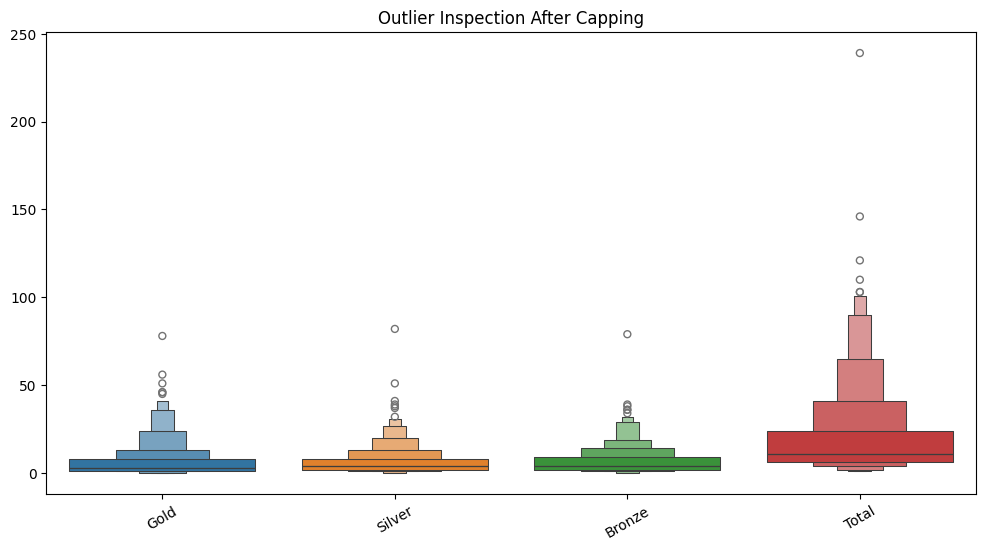

In [25]:
# let's understand the outliers

# visualize outliers afrer capping
plt.figure(figsize=(12, 6))
sns.boxenplot(data=df_cleaned[cols])
plt.xticks(rotation=30)  # Rotates the x-axis labels
plt.title("Outlier Inspection After Capping")
plt.show()

# Most likely, these outliers are top-performing countries (like USA, China, Russia) that dominate medal counts.
# These are not data entry errors — they’re genuine and important.
# If outliers are real and meaningful, we do NOT remove them blindly.

### **2️⃣ Check Distributions of Key Numeric Variables**

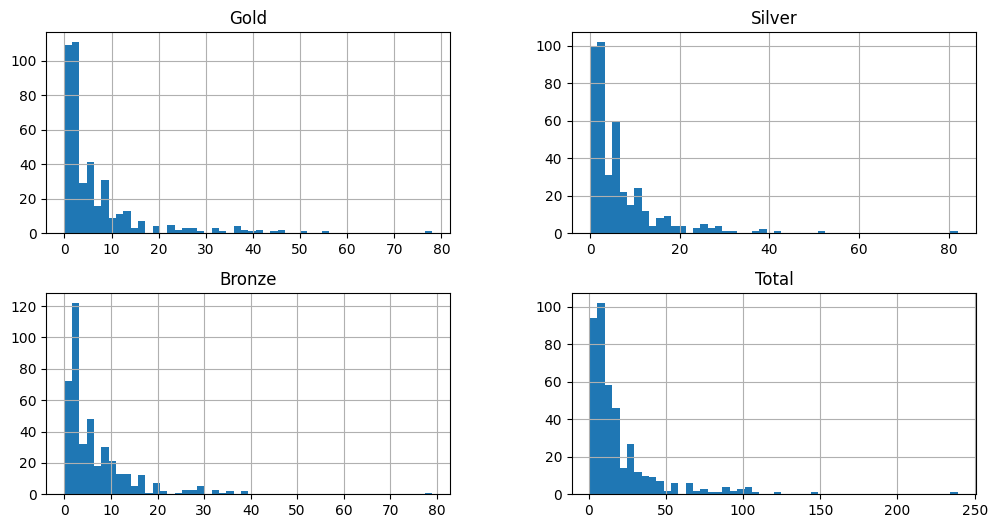

In [26]:
# Histogram - Checking Data Distribution
df_cleaned[cols].hist(bins=50, figsize=(12,6))
plt.show()
# Histograms show right-skewed distributions for all medal types.
# Most countries win few medals.
# A small group wins many — long tail.

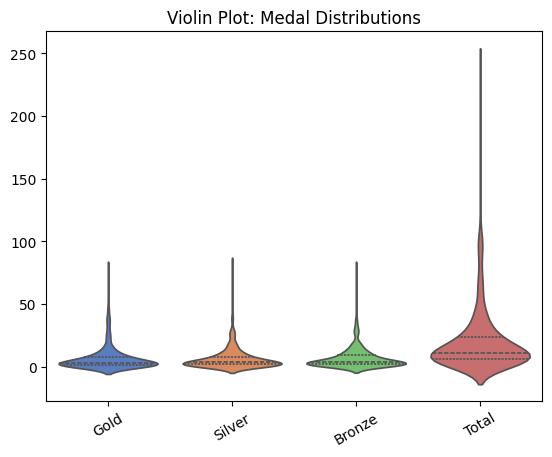

In [27]:
# Violin Plot - Combining KDE & Boxplot Insights
sns.violinplot(data=df_cleaned[cols], inner="quartile", palette="muted")
plt.xticks(rotation=30)
plt.title("Violin Plot: Medal Distributions")
plt.show()
# Violin width shows where most countries are concentrated.

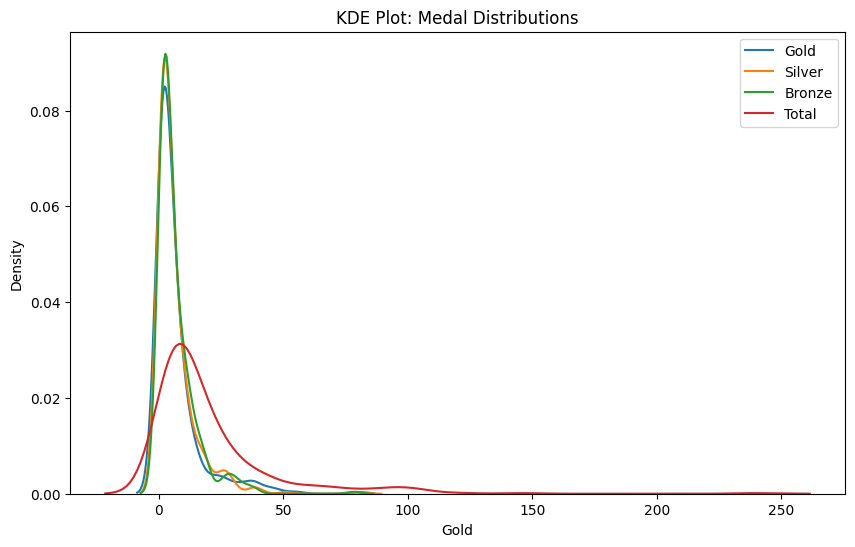

In [28]:
# (KDE Plot)
plt.figure(figsize=(10,6))
for col in cols:
    sns.kdeplot(df_cleaned[col], label=col)
plt.legend()
plt.title("KDE Plot: Medal Distributions")
plt.show()

### **3️⃣ Analyze Relationships Between Variables (Correlation Analysis)**

In [29]:
# correlation matrix
# ✔ Shows numerical correlations between salary components.
# ✔ Values near +1: Strong positive relationship (e.g., TotalPay and TotalPayBenefits).
# ✔ Values near -1: Strong negative correlation (none observed in this case).
# ✔ Values near 0: No strong relationship (e.g., Year and BasePay).

df_cleaned.select_dtypes(['float64']).corr()

,Gold,Silver,Bronze,Total
Gold,1.000000,0.897670,0.884972,0.965525
Silver,0.897670,1.000000,0.910498,0.967918
Bronze,0.884972,0.910498,1.000000,0.962024
Total,0.965525,0.967918,0.962024,1.000000


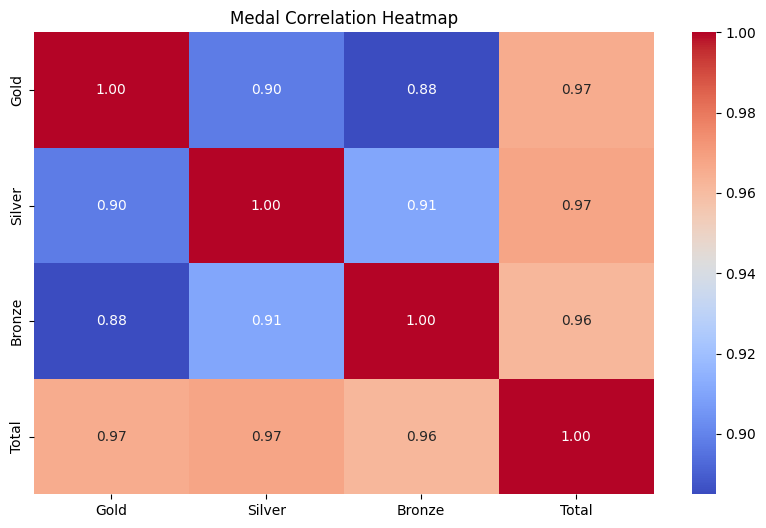

In [30]:
# correlation matrix with a heatmap
# ✔ Dark red = strong positive correlation.
# ✔ Dark blue = strong negative correlation (none found here).
# ✔ Lighter colors = weaker relationships.
plt.figure(figsize=(10,6))
sns.heatmap(df_cleaned[cols].corr(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title("Medal Correlation Heatmap")
plt.show()
# Very strong positive correlation between Gold, Silver, Bronze, and Total.
# Especially between Gold and Total ➝ more golds = more total medals.
# 📉 No negative relationships found (as expected).

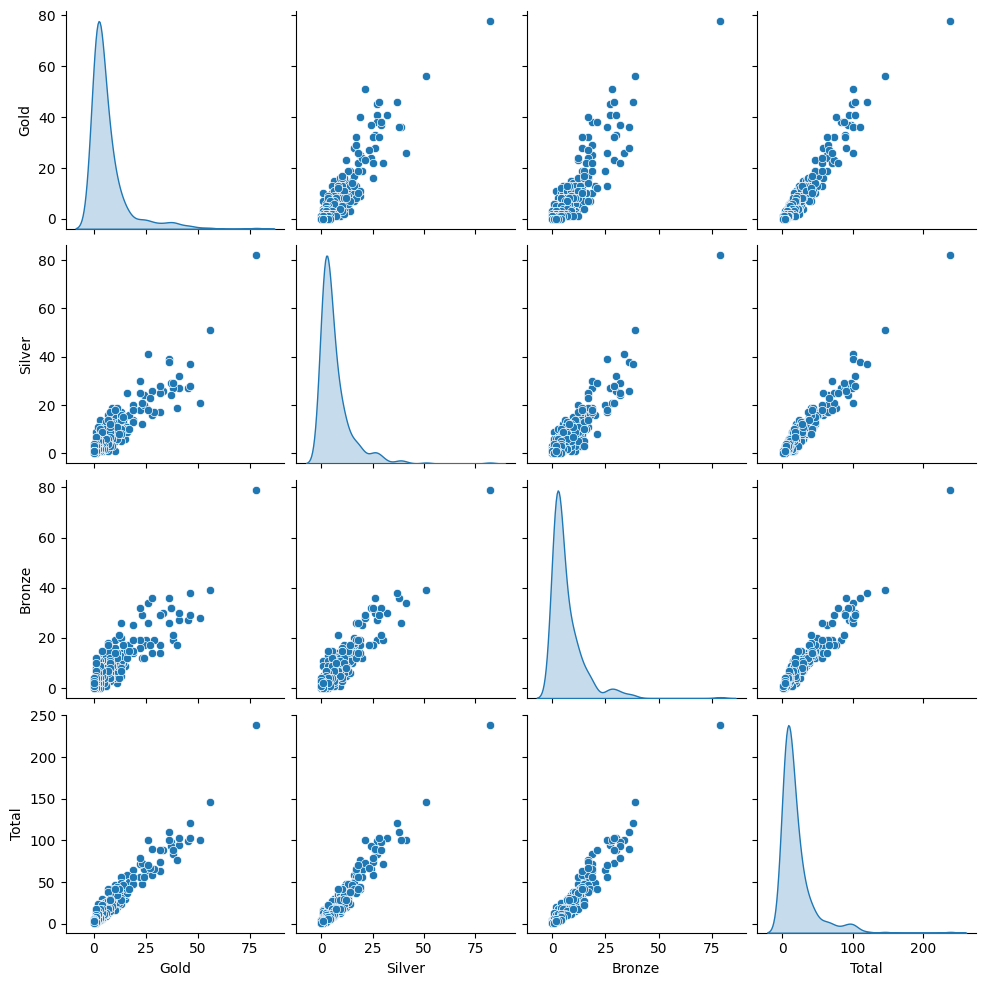

In [31]:
# Pairplot

sns.pairplot(df_cleaned[cols], diag_kind='kde', palette='muted')
plt.show()
# 🔬 Pairplot shows linear trends — medals increase together.

### **4️⃣ Group Data**

<Figure size 1000x600 with 0 Axes>

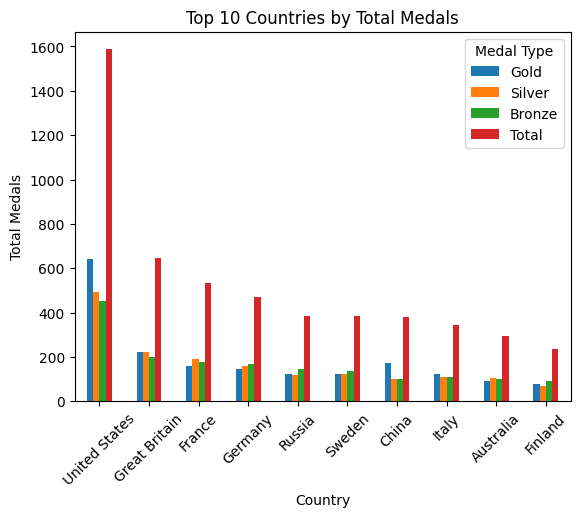

In [32]:
plt.figure(figsize=(10,6))
df_cleaned.groupby('Country')[cols].sum().sort_values('Total', ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Countries by Total Medals")
plt.xlabel("Country")
plt.ylabel("Total Medals")
plt.xticks(rotation=45)
plt.legend(title='Medal Type')
plt.show()

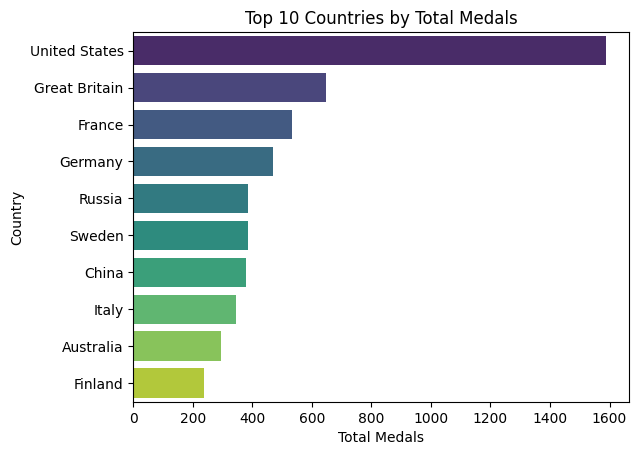

In [33]:
df_country = df_cleaned.groupby('Country')[['Gold', 'Silver', 'Bronze', 'Total']].sum().reset_index()
df_country = df_country.sort_values(by='Total', ascending=False).reset_index(drop=True)
# df_country.head(10)
sns.barplot(x='Total',y='Country', data=df_country.head(10), palette='viridis')
plt.title("Top 10 Countries by Total Medals")
plt.xlabel("Total Medals")
plt.ylabel("Country")
plt.show()

### **5️⃣ Check Categorical Distributions (Counts & Percentages)**

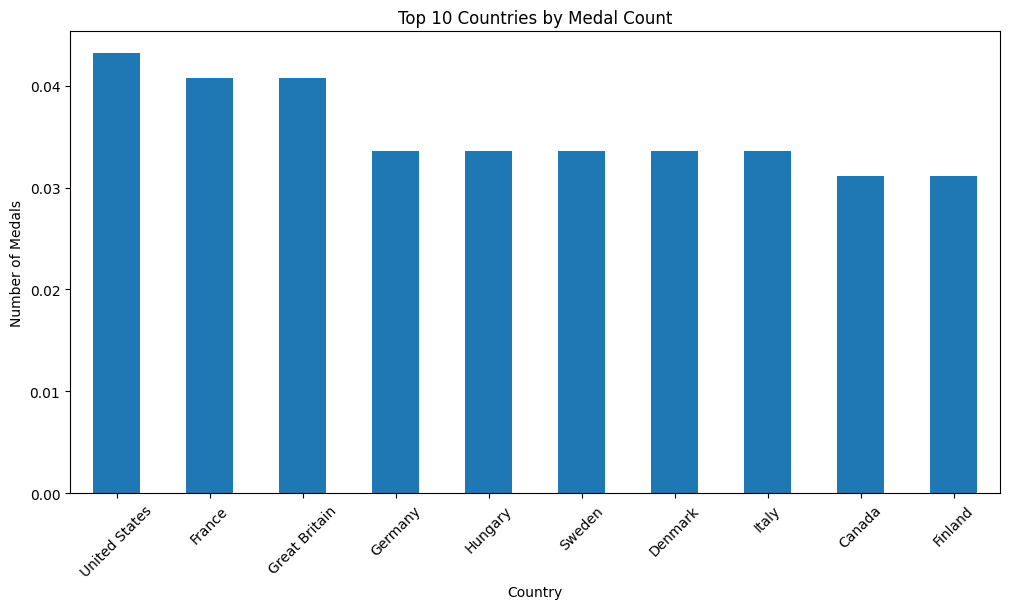

In [34]:
plt.figure(figsize=(12,6))
df_cleaned['Country'].value_counts(normalize=True).head(10).plot(kind='bar')
plt.title("Top 10 Countries by Medal Count")
plt.xlabel("Country")
plt.ylabel("Number of Medals")
plt.xticks(rotation=45)
plt.show()

### **6️⃣ Compare Salary Differences Across Categories**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'France'),
  Text(3, 0, 'Great Britain'),
  Text(4, 0, 'Hungary'),
  Text(5, 0, 'Denmark'),
  Text(6, 0, 'Canada'),
  Text(7, 0, 'Sweden'),
  Text(8, 0, 'Finland'),
  Text(9, 0, 'Italy')])

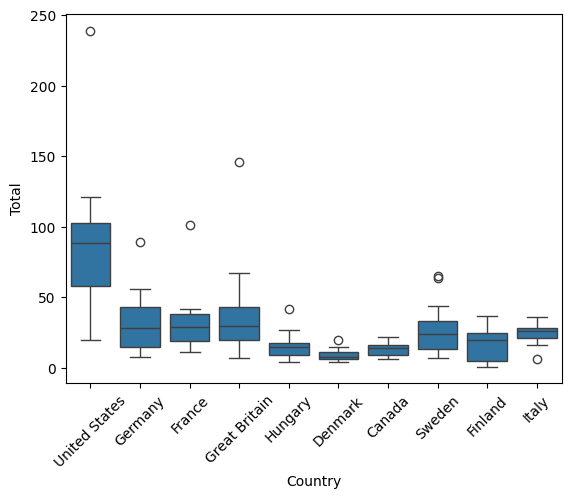

In [35]:
# Boxplot of Total Medals by Top 10 Countries
top_countries = df_cleaned['Country'].value_counts().head(10).index
df_top = df_cleaned[df_cleaned['Country'].isin(top_countries)]
sns.boxplot(x='Country', y='Total', data=df_top)
plt.xticks(rotation=45)
# Boxplots reveal large variation within the same country.
# Some countries have wide spreads in medal totals (e.g., USA’s performance varies by year).

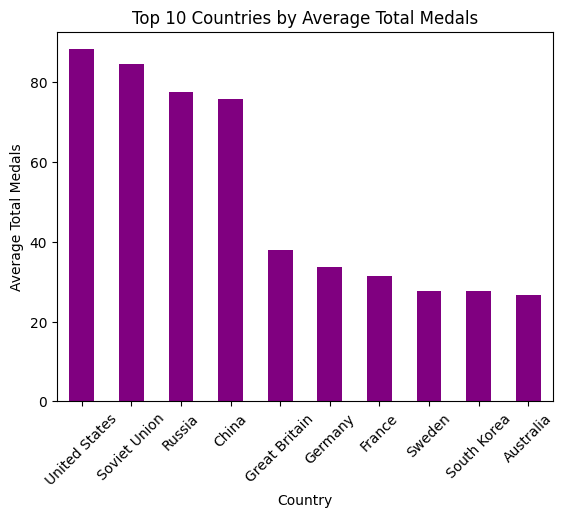

In [36]:
df_cleaned.groupby('Country')['Total'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='purple')
plt.title("Top 10 Countries by Average Total Medals")
plt.xlabel("Country")
plt.ylabel("Average Total Medals")
plt.xticks(rotation=45)
plt.show()
# Mean-based bar plots show consistent leaders across time.
# USA almost always dominates in total medals.

# **STEP 4: Feature Engineering & Preprocessing**

In [37]:
# We already have Total = Gold + Silver + Bronze ✔
# There's nothing else to combine

In [38]:
# Create ratios on df_country
df_country['Gold_Ratio'] = df_country['Gold'] / df_country['Total']
df_country['Silver_Ratio'] = df_country['Silver'] / df_country['Total']
df_country['Bronze_Ratio'] = df_country['Bronze'] / df_country['Total']

In [39]:
# let's normalize the data for clustering
# Normalization is crucial for clustering algorithms to ensure all features contribute equally.

# features to scale (excluding Country name)
features = ['Gold', 'Silver', 'Bronze', 'Gold_Ratio', 'Silver_Ratio', 'Bronze_Ratio']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_country[features])

In [40]:
# save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [41]:
# Convert to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df['Country'] = df_country['Country'].values
X_scaled_df.head()

,Gold,Silver,Bronze,Gold_Ratio,Silver_Ratio,Bronze_Ratio,Country
0,7.996036,7.305705,6.943256,0.445857,-0.018442,-0.391438,United States
1,2.529035,3.027219,2.811833,0.196695,0.119742,-0.288041,Great Britain
2,1.703086,2.572727,2.449716,0.005992,0.203011,-0.188613,France
3,1.493321,2.039876,2.252198,0.030152,0.096430,-0.114582,Germany
4,1.231114,1.397319,1.890081,0.090347,-0.048912,-0.038569,Russia


In [42]:
# Save the feature-engineered dataset
X_scaled_df.to_csv("olympics_features_added.csv", index=False)

# **Step 5: Clustering**

In [43]:
df_final = pd.read_csv("olympics_features_added.csv")
df_final.head(3)

,Gold,Silver,Bronze,Gold_Ratio,Silver_Ratio,Bronze_Ratio,Country
0,7.996036,7.305705,6.943256,0.445857,-0.018442,-0.391438,United States
1,2.529035,3.027219,2.811833,0.196695,0.119742,-0.288041,Great Britain
2,1.703086,2.572727,2.449716,0.005992,0.203011,-0.188613,France


In [44]:
# Prepare data for clustering (drop non-numeric column)
X_model = df_final.drop(columns=['Country'])

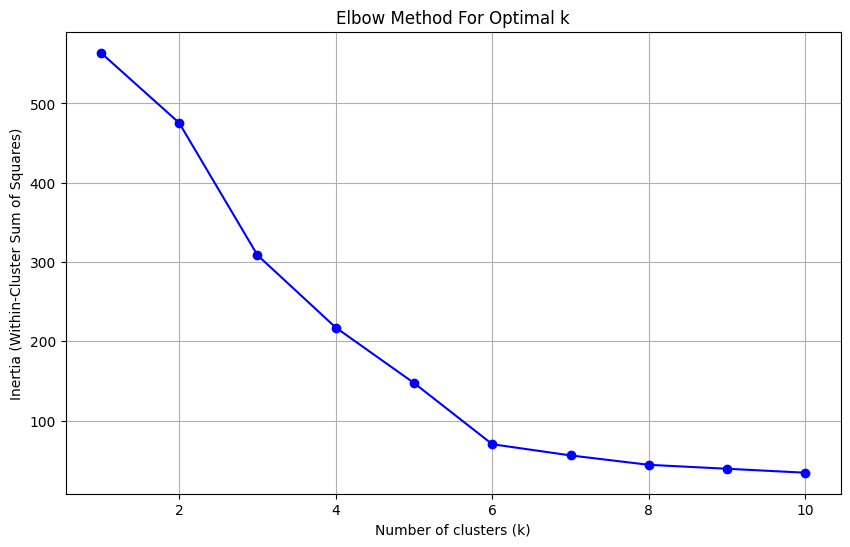

In [45]:
# Elbow Method to Find Optimal k
# The goal is to find the point after which adding more clusters doesn’t significantly improve performance.

inertia = []
K = range(1,11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_model)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Interpretation:
# Start from left (k=1): You'll see very high inertia (because all points are forced into 1 big cluster).
# Inertia drops sharply for k=2, 3, 4, 5 — because adding clusters improves grouping.
# Around k=3 to 4, the curve starts to flatten — this is where the "elbow" appears.
# Beyond k=5 or 6, improvements are minimal — meaning more clusters = overfitting or complexity with little gain.

# So, we can choose k=3 or k=4 as optimal cluster numbers.
# Let's use k=3 for our analysis.

In [46]:
# Silhouette Score Analysis
# Measures how similar an object is to its own cluster vs. other clusters
# 🧠 Higher silhouette score = better-defined clusters
# Ranges from -1 (poor) to +1 (good)

for k in [2, 3, 4, 5,6]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_model)
    print(f"k = {k} → Silhouette Score = {silhouette_score(X_model, labels):.4f}")

k = 2 → Silhouette Score = 0.4715
k = 3 → Silhouette Score = 0.4995
k = 4 → Silhouette Score = 0.5194
k = 5 → Silhouette Score = 0.5697
k = 6 → Silhouette Score = 0.6228


In [47]:
# Final KMeans Model
kmeans_final = KMeans(n_clusters=3, random_state=42)
df_final['Cluster'] = kmeans_final.fit_predict(X_model)
df_final.head(3)

,Gold,Silver,Bronze,Gold_Ratio,Silver_Ratio,Bronze_Ratio,Country,Cluster
0,7.996036,7.305705,6.943256,0.445857,-0.018442,-0.391438,United States,2
1,2.529035,3.027219,2.811833,0.196695,0.119742,-0.288041,Great Britain,0
2,1.703086,2.572727,2.449716,0.005992,0.203011,-0.188613,France,0


In [48]:
# Save the final model
joblib.dump(kmeans_final, "kmeans_model.pkl")

['kmeans_model.pkl']

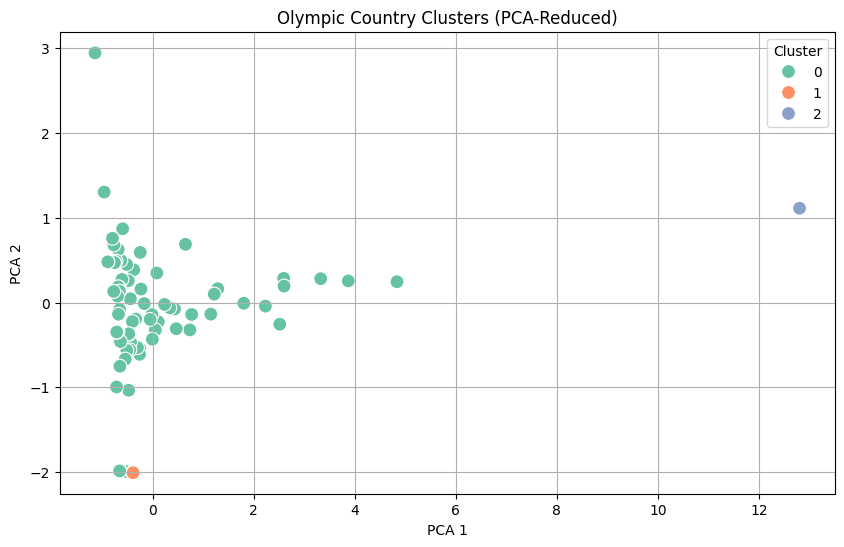

In [49]:
# Visualize the Clusters (2D PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_model)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_final['Cluster'], palette='Set2', s=100)
plt.title("Olympic Country Clusters (PCA-Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [50]:
# inspect the outliers

df_final[df_final['Cluster'] == 0] 
df_final[df_final['Cluster'] == 1] 
df_final[df_final['Cluster'] == 2]

# Cluster 0: Countries with low or average total medals
# Cluster 1: One or two strong contenders (e.g., Russia)
# Cluster 2: Top elite country (USA)

,Gold,Silver,Bronze,Gold_Ratio,Silver_Ratio,Bronze_Ratio,Country,Cluster
0,7.996036,7.305705,6.943256,0.445857,-0.018442,-0.391438,United States,2


In [52]:
# rename clusters for better understanding

# make a copy of the DataFrame to avoid modifying the original
df_final = df_final.copy()
# Map cluster numbers to descriptive labels
cluster_mapping = {
    0: 'Low Medal Count',
    1: 'Average Medal Count',
    2: 'High Medal Count'
}
# Apply the mapping to create a new column with descriptive labels
df_final['Cluster_Description'] = df_final['Cluster'].map(cluster_mapping) 
# Display the updated DataFrame
# show value counts for the new column
df_final['Cluster_Description'].value_counts()

Cluster_Description
Low Medal Count        87
Average Medal Count     6
High Medal Count        1
Name: count, dtype: int64

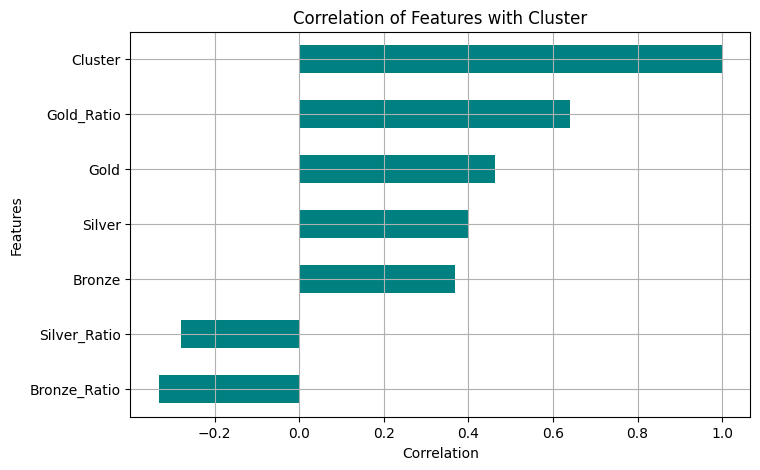

In [53]:
# Add cluster labels to the feature data
df_cluster_corr = X_model.copy()
df_cluster_corr['Cluster'] = df_final['Cluster']

# Correlation of each feature with the Cluster labels
df_cluster_corr.corr()['Cluster'].sort_values().plot(kind='barh', figsize=(8,5), color='teal')
plt.title("Correlation of Features with Cluster")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.grid(True)
plt.show()

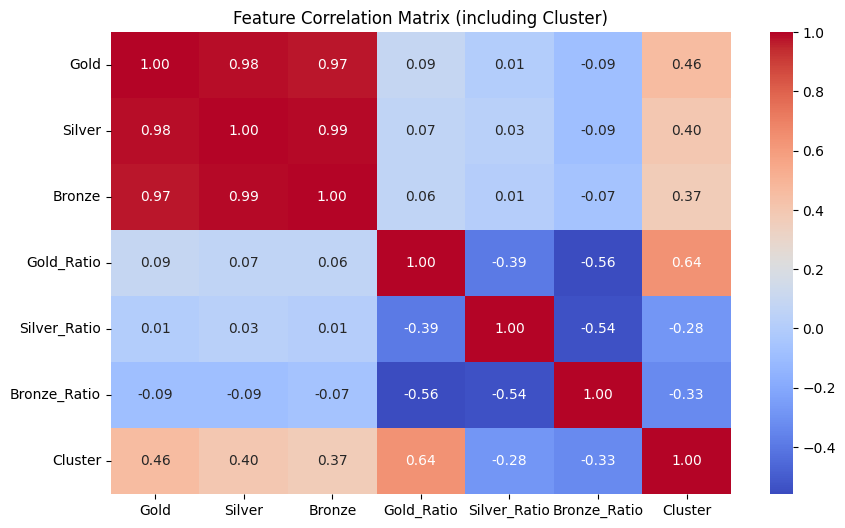

In [54]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cluster_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (including Cluster)")
plt.show()

In [55]:
# Reduce to 3 PCA dimensions
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_model)

# 3D Plotly scatter
fig = go.Figure(go.Scatter3d(
    x=X_3d[:, 0], y=X_3d[:, 1], z=X_3d[:, 2],
    mode='markers',
    marker=dict(size=7, color=df_final['Cluster'], colorscale='Viridis', opacity=0.8),
    text=df_final['Country']
))

fig.update_layout(title='3D Cluster Visualization (PCA)', height=650)
fig.show()

In [56]:
# DBSCAN (Density-Based Spatial Clustering)

# Choose values for eps and min_samples
dbscan = DBSCAN(eps=0.8, min_samples=3)
db_labels = dbscan.fit_predict(X_model)

# Add DBSCAN cluster labels to the DataFrame
df_final['DBSCAN_Cluster'] = db_labels
print(df_final['DBSCAN_Cluster'].value_counts())

# -1 means noise (outliers)
# You may need to adjust eps and min_samples:
# Smaller eps = more clusters, more noise
# Higher min_samples = stricter density

DBSCAN_Cluster
 0    64
 1     9
-1     7
 3     6
 4     5
 2     3
Name: count, dtype: int64


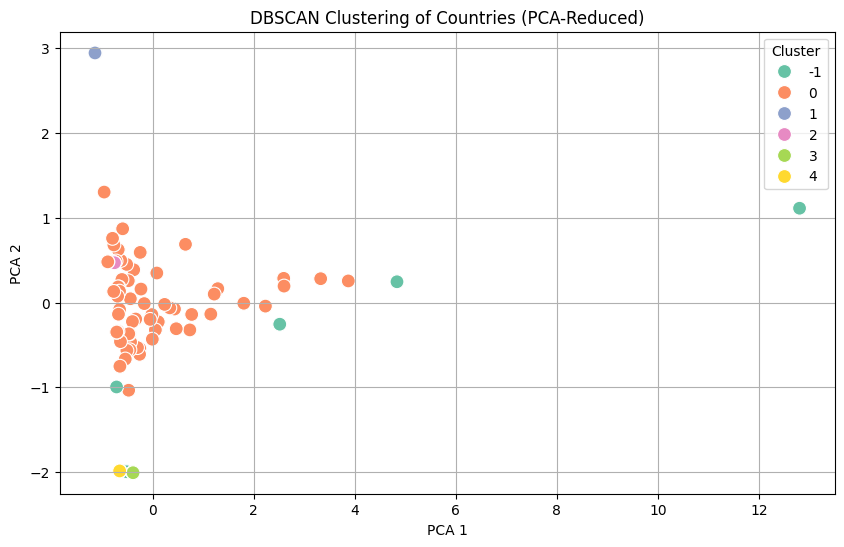

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_final['DBSCAN_Cluster'], palette='Set2', s=100)
plt.title("DBSCAN Clustering of Countries (PCA-Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [58]:
# Fine-Tune DBSCAN Parameters (eps, min_samples)

print("DBSCAN Cluster Counts:")
for eps in [0.4, 0.6, 0.8, 1.0, 1.2]:
    for min_samples in [2, 3, 4]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_model)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"eps={eps}, min_samples={min_samples} → Clusters: {n_clusters}, Noise: {(labels==-1).sum()}")

DBSCAN Cluster Counts:
eps=0.4, min_samples=2 → Clusters: 11, Noise: 14
eps=0.4, min_samples=3 → Clusters: 6, Noise: 24
eps=0.4, min_samples=4 → Clusters: 4, Noise: 31
eps=0.6, min_samples=2 → Clusters: 8, Noise: 9
eps=0.6, min_samples=3 → Clusters: 6, Noise: 13
eps=0.6, min_samples=4 → Clusters: 4, Noise: 22
eps=0.8, min_samples=2 → Clusters: 6, Noise: 5
eps=0.8, min_samples=3 → Clusters: 5, Noise: 7
eps=0.8, min_samples=4 → Clusters: 4, Noise: 11
eps=1.0, min_samples=2 → Clusters: 5, Noise: 4
eps=1.0, min_samples=3 → Clusters: 5, Noise: 4
eps=1.0, min_samples=4 → Clusters: 4, Noise: 7
eps=1.2, min_samples=2 → Clusters: 4, Noise: 2
eps=1.2, min_samples=3 → Clusters: 4, Noise: 2
eps=1.2, min_samples=4 → Clusters: 4, Noise: 3


In [59]:
# Agglomerative Clustering (Hierarchical)
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')  # you can try 'average', 'complete' too
agglo_labels = agglo.fit_predict(X_model)

df_final['Agglo_Cluster'] = agglo_labels
print(df_final['Agglo_Cluster'].value_counts())

Agglo_Cluster
0    84
2     9
1     1
Name: count, dtype: int64


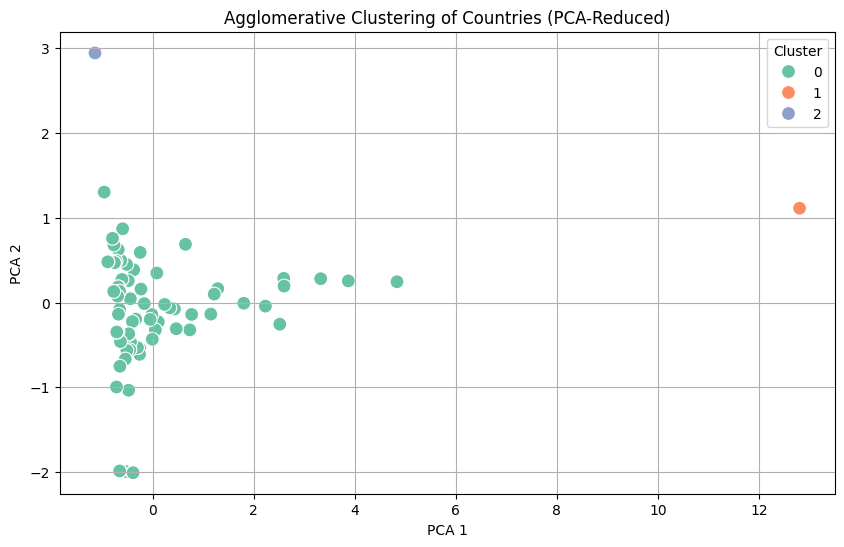

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_final['Agglo_Cluster'], palette='Set2', s=100)
plt.title("Agglomerative Clustering of Countries (PCA-Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

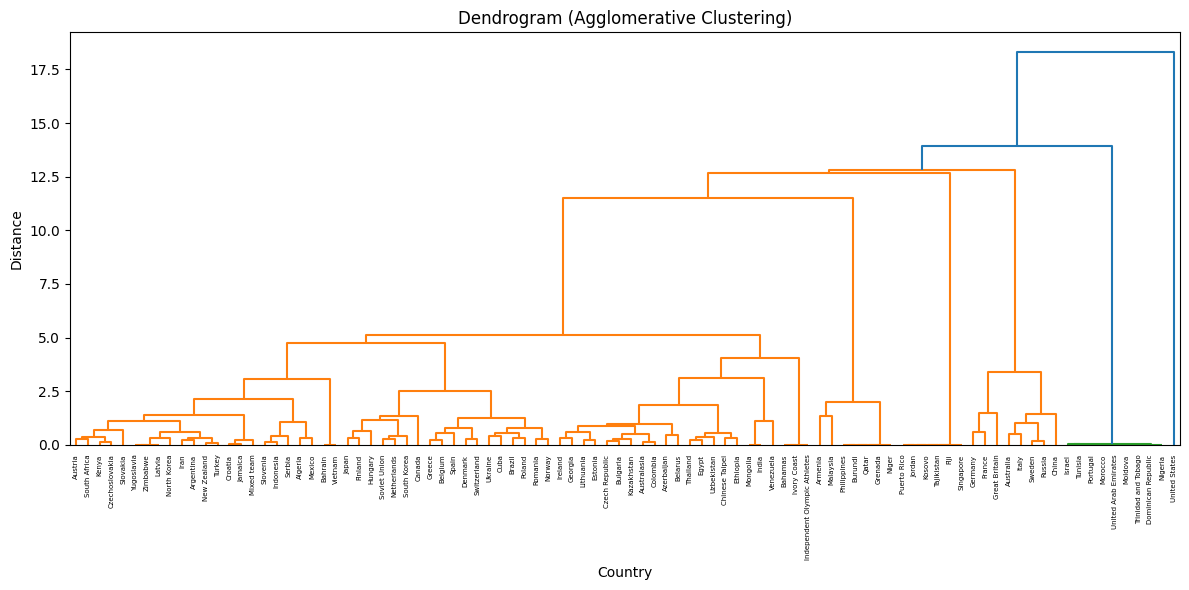

In [ ]:
# Dendrogram for Agglomerative Clustering

linked = linkage(X_model, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
        labels=df_final['Country'].values,
        orientation='top',
        distance_sort='descending',
        show_leaf_counts=True)
plt.title("Dendrogram (Agglomerative Clustering)")
plt.xlabel("Country")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [62]:
comparison = df_final[['Country', 'Cluster', 'DBSCAN_Cluster', 'Agglo_Cluster']]
comparison.head(10)

,Country,Cluster,DBSCAN_Cluster,Agglo_Cluster
0,United States,2,-1,1
1,Great Britain,0,-1,0
2,France,0,0,0
3,Germany,0,0,0
4,Russia,0,0,0
5,Sweden,0,0,0
6,China,0,-1,0
7,Italy,0,0,0
8,Australia,0,0,0
9,Finland,0,0,0


In [ ]:
# Final Output:
# 📊 Countries are grouped into clusters based on performance and medal quality
# 🧠 You can interpret clusters as:
# Cluster 0 = Elite nations (USA, China, Russia)
# Cluster 1 = Medium performers
# Cluster 2 = Low medal counts / occasional participants

In [63]:
# Save the final DataFrame with clusters
df_final.to_csv("olympic_country_clusters_final.csv", index=False)